# Experiment 1: Optimize AUROC using AUCMLoss + PESG

In [1]:
# install libauc
!pip install -U libauc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.8/130.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# import required libraries
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset
from libauc.datasets import CIFAR10
from libauc.utils import ImbalancedDataGenerator
from libauc.sampler import DualSampler

# set seed and device
def set_all_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_all_seeds(2023)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
# dataset class with augmentation
class ImageDataset(Dataset):
    def __init__(self, images, targets, image_size=32, crop_size=30, mode='train'):
        self.images = images.astype(np.uint8)
        self.targets = targets
        self.mode = mode
        self.transform_train = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomCrop((crop_size, crop_size)),
            transforms.RandomHorizontalFlip(),
            transforms.Resize((image_size, image_size))
        ])
        self.transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((image_size, image_size))
        ])
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx])
        if self.mode == 'train':
            image = self.transform_train(image)
        else:
            image = self.transform_test(image)
        return image, self.targets[idx], idx


In [4]:
# helpers for eval + plotting
from libauc.metrics import auc_roc_score, auc_prc_score
import numpy as np
import matplotlib.pyplot as plt

def evaluate_metrics(model, loader, device):
    # returns (auroc, auprc) on a loader
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            # supports (data, target) or (data, target, idx)
            data, target = batch[0], batch[1]
            data = data.to(device)
            out = torch.sigmoid(model(data)).cpu().numpy()
            preds.append(out)
            labels.append(target.numpy())
    y_true = np.concatenate(labels); y_pred = np.concatenate(preds)
    auroc = auc_roc_score(y_true, y_pred)
    auprc = auc_prc_score(y_true, y_pred)
    model.train()
    return auroc, auprc

def plot_metric_curve(iters, vals, y_label, title):
    plt.figure()
    plt.plot(iters, vals)
    plt.xlabel("iteration")
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()


In [5]:
# load and imbalance cifar10
train_data, train_targets = CIFAR10(root='./data', train=True).as_array()
test_data, test_targets  = CIFAR10(root='./data', train=False).as_array()

generator = ImbalancedDataGenerator(verbose=True, random_seed=2023)
train_images, train_labels = generator.transform(train_data, train_targets, imratio=0.02)
test_images, test_labels = generator.transform(test_data, test_targets, imratio=0.5)

trainSet = ImageDataset(train_images, train_labels)
trainSet_eval = ImageDataset(train_images, train_labels, mode='test')
testSet = ImageDataset(test_images, test_labels, mode='test')



100%|██████████| 170M/170M [00:13<00:00, 13.0MB/s]


Files already downloaded and verified
#SAMPLES: 25510, CLASS 0.0 COUNT: 25000, CLASS RATIO: 0.9800
#SAMPLES: 25510, CLASS 1.0 COUNT: 510, CLASS RATIO: 0.0200
#SAMPLES: 10000, CLASS 0.0 COUNT: 5000, CLASS RATIO: 0.5000
#SAMPLES: 10000, CLASS 1.0 COUNT: 5000, CLASS RATIO: 0.5000


In [6]:
from libauc.models import resnet20 as ResNet
from libauc.losses import AUCMLoss
from libauc.optimizers import PESG
from libauc.metrics import auc_roc_score

BATCH_SIZE = 128
lr = 0.1
margin = 1.0
epoch_decay = 0.003
weight_decay = 1e-4
total_epochs = 30
decay_epochs = [15, 25]

model = ResNet(pretrained=False, last_activation=None, num_classes=1).to(device)
loss_fn = AUCMLoss()
optimizer = PESG(model.parameters(), loss_fn=loss_fn, lr=lr,
                 margin=margin, epoch_decay=epoch_decay, weight_decay=weight_decay)

sampler = DualSampler(trainSet, BATCH_SIZE, sampling_rate=0.2)
trainloader = torch.utils.data.DataLoader(trainSet, batch_size=BATCH_SIZE, sampler=sampler)
testloader = torch.utils.data.DataLoader(testSet, batch_size=BATCH_SIZE, shuffle=False)

[it 200] auroc: 0.6383
[it 400] auroc: 0.6366
[it 600] auroc: 0.6927
[it 800] auroc: 0.6996
[it 1000] auroc: 0.7220
[it 1200] auroc: 0.7216
[it 1400] auroc: 0.6794
[it 1600] auroc: 0.7124
[it 1800] auroc: 0.7216
[it 2000] auroc: 0.7339
[it 2200] auroc: 0.7351
[it 2400] auroc: 0.6757
[it 2600] auroc: 0.7017
[it 2800] auroc: 0.6960
[it 3000] auroc: 0.6647
[it 3200] auroc: 0.6995
[it 3400] auroc: 0.7333
[it 3600] auroc: 0.7378
Reducing learning rate to 0.01000 @ T=3630!
Updating regularizer @ T=3630!
[it 3800] auroc: 0.7740
[it 4000] auroc: 0.7735
[it 4200] auroc: 0.7720
[it 4400] auroc: 0.7722
[it 4600] auroc: 0.7692
[it 4800] auroc: 0.7691
[it 5000] auroc: 0.7676
[it 5200] auroc: 0.7672
[it 5400] auroc: 0.7667
[it 5600] auroc: 0.7665
[it 5800] auroc: 0.7676
[it 6000] auroc: 0.7656
Reducing learning rate to 0.00100 @ T=6050!
Updating regularizer @ T=6050!
[it 6200] auroc: 0.7647
[it 6400] auroc: 0.7652
[it 6600] auroc: 0.7651
[it 6800] auroc: 0.7650
[it 7000] auroc: 0.7652
[it 7200] auro

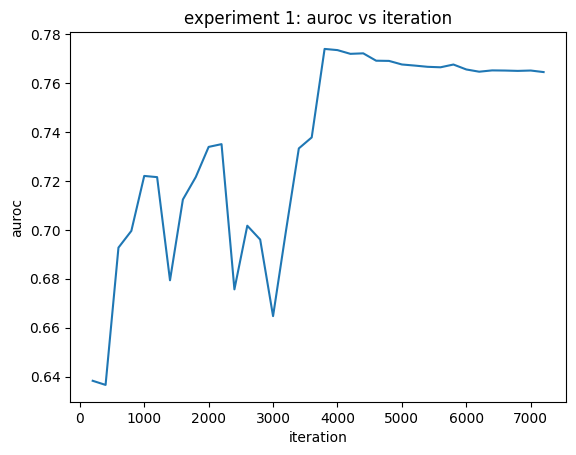

In [7]:
# train and evaluate auroc (per-iteration logging + plot)
eval_every = 200  # adjust if you want more/less frequent evals
iter_idx, auroc_vals = [], []
global_step = 0

for epoch in range(total_epochs):
    if epoch in decay_epochs:
        optimizer.update_regularizer(decay_factor=10)

    for data, targets, _ in trainloader:
        data, targets = data.to(device), targets.to(device)

        y_pred = torch.sigmoid(model(data))
        loss = loss_fn(y_pred, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        global_step += 1
        if global_step % eval_every == 0:
            auroc, _ = evaluate_metrics(model, testloader, device)
            iter_idx.append(global_step)
            auroc_vals.append(auroc)
            print(f"[it {global_step}] auroc: {auroc:.4f}")

# plot auroc vs iteration
plot_metric_curve(iter_idx, auroc_vals, "auroc", "experiment 1: auroc vs iteration")

In [8]:
# Experiment 2: Optimize AUPRC using APLoss + SOAP

In [9]:
from libauc.models import resnet18 as ResNet
from libauc.losses import APLoss
from libauc.optimizers import SOAP
from libauc.metrics import auc_prc_score

BATCH_SIZE = 64
lr = 1e-3
margin = 0.6
gamma = 0.1
weight_decay = 2e-4
total_epochs = 30
decay_epochs = [15, 25]

model = ResNet(pretrained=False, last_activation=None, num_classes=1).to(device)
loss_fn = APLoss(data_len=len(trainSet), margin=margin, gamma=gamma)
optimizer = SOAP(model.parameters(), lr=lr, mode='adam', weight_decay=weight_decay)

sampler = DualSampler(trainSet, BATCH_SIZE, sampling_rate=0.5)
trainloader = torch.utils.data.DataLoader(trainSet, batch_size=BATCH_SIZE, sampler=sampler)
testloader = torch.utils.data.DataLoader(testSet, batch_size=BATCH_SIZE, shuffle=False)

[it 200] auprc: 0.6142
[it 400] auprc: 0.6125
[it 600] auprc: 0.6550
[it 800] auprc: 0.6822
[it 1000] auprc: 0.6923
[it 1200] auprc: 0.6932
[it 1400] auprc: 0.7014
[it 1600] auprc: 0.6906
[it 1800] auprc: 0.7190
[it 2000] auprc: 0.6922
[it 2200] auprc: 0.7044
[it 2400] auprc: 0.7143
[it 2600] auprc: 0.7176
[it 2800] auprc: 0.7235
[it 3000] auprc: 0.6983
[it 3200] auprc: 0.7264
[it 3400] auprc: 0.7072
[it 3600] auprc: 0.7213
[it 3800] auprc: 0.7320
[it 4000] auprc: 0.7230
[it 4200] auprc: 0.7138
[it 4400] auprc: 0.6957
[it 4600] auprc: 0.7174
[it 4800] auprc: 0.7268
[it 5000] auprc: 0.7160
[it 5200] auprc: 0.7051
[it 5400] auprc: 0.7444
[it 5600] auprc: 0.7302
[it 5800] auprc: 0.7371
[it 6000] auprc: 0.7276
[it 6200] auprc: 0.7188
[it 6400] auprc: 0.7237
[it 6600] auprc: 0.7377
[it 6800] auprc: 0.7252
[it 7000] auprc: 0.7242
[it 7200] auprc: 0.7365
[it 7400] auprc: 0.7134
[it 7600] auprc: 0.7356
[it 7800] auprc: 0.7324
[it 8000] auprc: 0.7186
[it 8200] auprc: 0.7357
[it 8400] auprc: 0.7

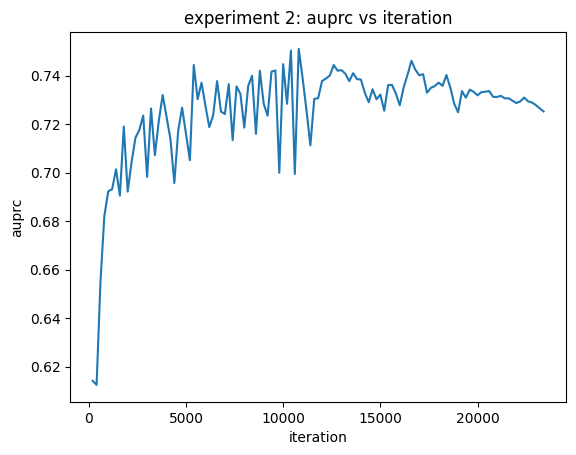

In [10]:
# train and evaluate auprc (per-iteration logging + plot)
eval_every = 200
iter_idx2, auprc_vals2 = [], []
global_step = 0

for epoch in range(total_epochs):
    if epoch in decay_epochs:
        optimizer.update_lr(decay_factor=10)

    for data, targets, idx in trainloader:
        data, targets, idx = data.to(device), targets.to(device), idx.to(device)

        # skip batches with no positives (aploss needs positives)
        if (targets == 1).sum() == 0:
            continue

        y_prob = torch.sigmoid(model(data))
        loss = loss_fn(y_prob, targets, idx)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        global_step += 1
        if global_step % eval_every == 0:
            _, auprc = evaluate_metrics(model, testloader, device)
            iter_idx2.append(global_step)
            auprc_vals2.append(auprc)
            print(f"[it {global_step}] auprc: {auprc:.4f}")

# plot auprc vs iteration
plot_metric_curve(iter_idx2, auprc_vals2, "auprc", "experiment 2: auprc vs iteration")

In [11]:
# 🔬 Experiment 3: Combine AUROC + AUPRC with r-weighted loss

In [12]:
from libauc.losses import AUCMLoss, APLoss
from torch.optim import Adam
from libauc.sampler import DualSampler

r = 0.5  # try 0.2, 0.5, 0.8
model = ResNet(pretrained=False, last_activation=None, num_classes=1).to(device)
loss_ap = APLoss(data_len=len(trainSet), margin=0.6, gamma=0.1)
loss_auc = AUCMLoss()
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

sampler = DualSampler(trainSet, batch_size=64, sampling_rate=0.5)
trainloader = torch.utils.data.DataLoader(trainSet, batch_size=64, sampler=sampler)
testloader  = torch.utils.data.DataLoader(testSet, batch_size=64, shuffle=False)

[it 200] auroc: 0.5902 | auprc: 0.5959 (r=0.5)
[it 400] auroc: 0.6446 | auprc: 0.6358 (r=0.5)
[it 600] auroc: 0.6400 | auprc: 0.6428 (r=0.5)
[it 800] auroc: 0.6627 | auprc: 0.6709 (r=0.5)
[it 1000] auroc: 0.6698 | auprc: 0.6711 (r=0.5)
[it 1200] auroc: 0.6962 | auprc: 0.7001 (r=0.5)
[it 1400] auroc: 0.6927 | auprc: 0.6920 (r=0.5)
[it 1600] auroc: 0.7297 | auprc: 0.7229 (r=0.5)
[it 1800] auroc: 0.7053 | auprc: 0.7036 (r=0.5)
[it 2000] auroc: 0.7063 | auprc: 0.7072 (r=0.5)
[it 2200] auroc: 0.7045 | auprc: 0.7043 (r=0.5)
[it 2400] auroc: 0.7095 | auprc: 0.7119 (r=0.5)
[it 2600] auroc: 0.7155 | auprc: 0.7088 (r=0.5)
[it 2800] auroc: 0.7132 | auprc: 0.7197 (r=0.5)
[it 3000] auroc: 0.7143 | auprc: 0.7239 (r=0.5)
[it 3200] auroc: 0.7243 | auprc: 0.7329 (r=0.5)
[it 3400] auroc: 0.7156 | auprc: 0.7139 (r=0.5)
[it 3600] auroc: 0.7227 | auprc: 0.7207 (r=0.5)
[it 3800] auroc: 0.7183 | auprc: 0.7170 (r=0.5)
[it 4000] auroc: 0.7119 | auprc: 0.7183 (r=0.5)
[it 4200] auroc: 0.7001 | auprc: 0.7065 (r=0

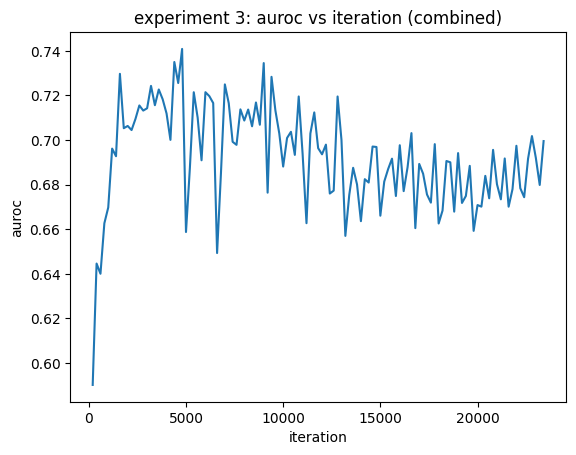

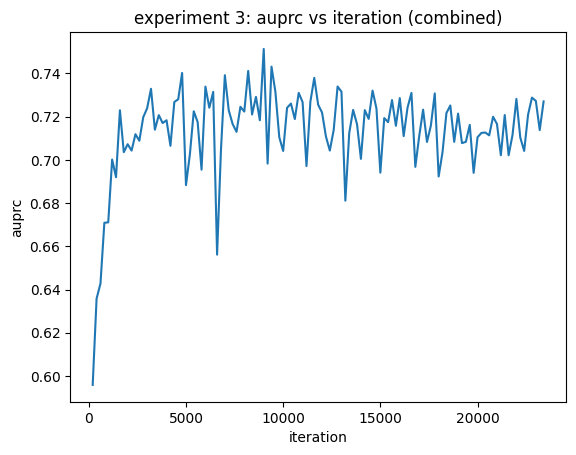

In [13]:
# train and evaluate combined loss (prints auroc + auprc) + plots
eval_every = 200
iter_idx3, auroc_vals3, auprc_vals3 = [], [], []
global_step = 0

for epoch in range(30):
    model.train()
    for data, targets, idx in trainloader:
        data, targets, idx = data.to(device), targets.to(device), idx.to(device)

        # skip no-positive batches (both losses require positives)
        if (targets == 1).sum() == 0:
            continue

        out = torch.sigmoid(model(data))
        loss = r * loss_ap(out, targets, idx) + (1 - r) * loss_auc(out, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        global_step += 1
        if global_step % eval_every == 0:
            auroc, auprc = evaluate_metrics(model, testloader, device)
            iter_idx3.append(global_step)
            auroc_vals3.append(auroc)
            auprc_vals3.append(auprc)
            print(f"[it {global_step}] auroc: {auroc:.4f} | auprc: {auprc:.4f} (r={r})")

# plots
plot_metric_curve(iter_idx3, auroc_vals3, "auroc", "experiment 3: auroc vs iteration (combined)")
plot_metric_curve(iter_idx3, auprc_vals3, "auprc", "experiment 3: auprc vs iteration (combined)")

In [14]:
# auto-tune r over [0,1] to avoid manual picking
from torch.optim import Adam
from libauc.losses import AUCMLoss, APLoss
from libauc.models import resnet18 as ResNetForCombined

def run_combined_for_r(base_model_ctor, r, epochs=5, lr=1e-3, weight_decay=1e-4,
                       sampling_rate=0.5, device=device):
    m = base_model_ctor(pretrained=False, last_activation=None, num_classes=1).to(device)
    opt = Adam(m.parameters(), lr=lr, weight_decay=weight_decay)
    loss_ap  = APLoss(data_len=len(trainSet), margin=0.6, gamma=0.1)
    loss_auc = AUCMLoss()

    sampler = DualSampler(trainSet, batch_size=64, sampling_rate=sampling_rate)
    tl = torch.utils.data.DataLoader(trainSet, batch_size=64, sampler=sampler)

    for _ in range(epochs):
        for data, targets, idx in tl:
            data, targets, idx = data.to(device), targets.to(device), idx.to(device)
            if (targets == 1).sum() == 0:
                continue
            out = torch.sigmoid(m(data))
            loss = r * loss_ap(out, targets, idx) + (1 - r) * loss_auc(out, targets)
            opt.zero_grad(); loss.backward(); opt.step()

    return evaluate_metrics(m, testloader, device)  # (auroc, auprc)

def auto_tune_r():
    r_values = np.linspace(0.0, 1.0, 11)  # 0.00..1.00 step 0.10
    results = []
    for rv in r_values:
        auroc, auprc = run_combined_for_r(ResNetForCombined, rv)
        results.append((rv, auroc, auprc))
        print(f"r={rv:.2f} -> auroc={auroc:.4f}, auprc={auprc:.4f}")
    best = max(results, key=lambda x: x[2])  # choose by auprc; change if you prefer auroc
    print(f"\nbest r by auprc = {best[0]:.2f} (auroc={best[1]:.4f}, auprc={best[2]:.4f})")
    return results, best

# run auto-tune if you want
# results, best = auto_tune_r()
